# Workbook for testing and documenting the Python Algorithms
> After finalizign algorithm here, it will be added to the main project under streamlit so it runs natively on the backend

In [ ]:
import math
import numpy as np
from scipy.interpolate import Rbf, thi
import plotly.graph_objects as go
import pandas as pd
import yfinance as yf
from scipy.optimize import brentq
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from time import time
from datetime import datetime, timedelta, timezone
from functools import wraps, lru_cache
import collections
import matplotlib.pyplot as plt

In [3]:
def calc_runtime(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        print(f"{func.__name__}({args, kwargs}) executed in ", end="")
        print(f"{end_time - start_time:.6f} seconds")
        return result
    return wrapper

# Initialize input data

In [4]:
S0 = 100.0     # Initial Stock Price
K = 120.0      # Strike Price
r = 0.06      # Risk-free interest rate
T = 5          # Time to maturity in years
N = 2000        # Number of time steps
vol = 0.2      # Volatility of the underlying stock (user input)
opttype = "C"  # "C" for Call, "P" for Put  
optclass = "E" # European or American option


# CRR values
### Calculating the up (up) and down (d) values using volatility (σ)

## CRR using infered σ from u and d

In [5]:
# u and d inferered from CRR model

## CRR using implied σ
> found by reverse calculating σ from option market price

In [6]:
# connect too Yahoo Finance to get stock/option data
def implied_volatility(symbol, S0, K, r, T, market_price, opttype):
    # Function to calculate implied volatility
    pass  # Implementation goes here

def crr_up_down(vol, dt):
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    return u, d

# Binmoial Method Algorithm

### Python Dynamic Programming

In [7]:
def binomial_option_price_dp(S0, K, T, r, N, u, d, opttype='C', optclass="E") -> float:
    """
    This algorithm uses dynamic programming to store option values at each node,
    iteratively calculating values from maturity back to the present.

    Only stores one layer of option values at a time to optimize space.

    Complexity:
    Time: O(N^2)
    Space: O(N)
    """

    dt = T / N
    q = (np.exp(r * dt) - d) / (u - d) # risk-neutral probability
    discount = np.exp(-r * dt)

    # Initialize asset prices at maturity
    S = np.zeros(N + 1) # [0, 0, .. N]
    S[0] = S0 * (d ** N) # [S0, 0, .. N]

    # Build the asset price tree
    for up_move in range(1, N+1):
        # Going up the tree
        S[up_move] = S[up_move - 1] * (u / d)

    # Initialize option values at maturity
    option_values = np.zeros(N + 1) # [0, 0, .. N]
    for up_move in range(N + 1):
        if opttype == 'C':
            option_values[up_move] = max(0, S[up_move] - K)
        else:
            option_values[up_move] = max(0, K - S[up_move])

    # Backward induction
    for step in range(N - 1, -1, -1):
        for up_move in range(step + 1):
            option_values[up_move] = discount * (q * option_values[up_move + 1] + (1 - q) * option_values[up_move]) # binomial formula
            if optclass == "A":
                # American option early exercise check
                if opttype == 'C':
                    option_values[up_move] = max(
                        option_values[up_move], 
                        S0 * (u ** up_move) * (d ** (step - up_move)) - K
                        )
                else:
                    option_values[up_move] = max(
                        option_values[up_move], 
                        K - S0 * (u ** up_move) * (d ** (step - up_move))
                        )
            else:
                pass  # European option, no early exercise

    return np.round(option_values[0], 4)


### NumPy Vectorization

In [8]:
def binomial_option_price_npv(S0, K, T, r, N, u, d, opttype='C', optclass="E") -> float:
    """
    This algorithm uses dynamic programming to store option values at each node,
    iteratively calculating values from maturity back to the present.

    Only stores one layer of option values at a time to optimize space.

    Complexity:
    Time: O(N^2)
    Space: O(N)
    """

    dt = T / N
    q = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    # Initialize asset prices at maturity
    j = np.arange(N + 1)
    S = S0 * (u ** j) * (d ** (N - j))

    # Initialize option values at maturity
    if opttype == 'C':
        option_values = np.maximum(0.0, S - K)
    else:
        option_values =  np.maximum(0.0, K - S)

    # Backward induction
    for step in range(N - 1, -1, -1):
        option_values[:step+1] = discount * (
            q * option_values[1:step+2] + (1 - q) * option_values[:step+1]
        )

        # American early exercise check (also vectorized)
        if optclass == "A":
            j = np.arange(step + 1)
            S_ij = S0 * (u ** j) * (d ** (step - j))  # stock price at node (i,j)

            if opttype == "C":
                exercise = np.maximum(S_ij - K, 0.0)
            else:
                exercise = np.maximum(K - S_ij, 0.0)

            option_values[:step+1] = np.maximum(option_values[:step+1], exercise)

    return option_values[0]


## Tests

In [9]:
u, d = crr_up_down(vol, T / N)
print(binomial_option_price_dp(S0, K, T, r, N, u, d, opttype, optclass))
print(binomial_option_price_npv(S0, K, T, r, N, u, d, opttype, optclass))

22.8256
22.825582703295087


## Black-Scholes Convergence

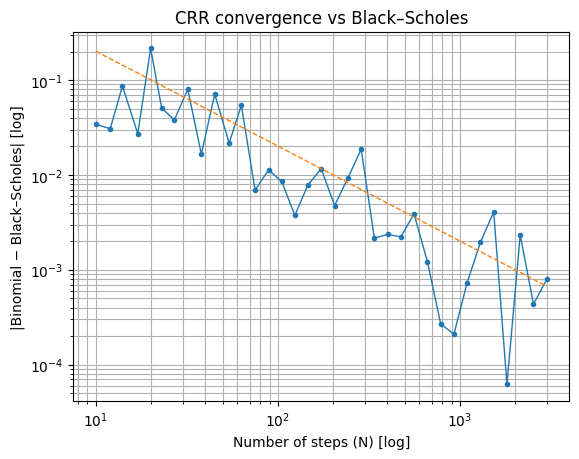

In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Normal CDF
# -------------------------
_INV_SQRT2 = 1.0 / math.sqrt(2.0)

def norm_cdf(x: float) -> float:
    """Standard normal CDF using erf; stable and fast."""
    return 0.5 * (1.0 + math.erf(x * _INV_SQRT2))

# -------------------------
# Black–Scholes price
# -------------------------
def bs_price(S0: float, K: float, r: float, T: float, vol: float, opttype: str = "C") -> float:
    """
    Black–Scholes price for European options, no dividends.
    opttype: 'C' (call) or 'P' (put)
    """
    if S0 <= 0 or K <= 0:
        raise ValueError("S0 and K must be > 0.")
    if T <= 0:
        # At expiry: value = intrinsic
        if opttype.upper().startswith("C"):
            return max(S0 - K, 0.0)
        return max(K - S0, 0.0)
    if vol <= 0:
        # Deterministic forward
        fwd = S0 * math.exp(r * T)
        discK = K * math.exp(-r * T)
        if opttype.upper().startswith("C"):
            return max(S0 - discK, 0.0) if fwd > K else 0.0
        return max(discK - S0, 0.0) if fwd < K else 0.0

    sqrtT = math.sqrt(T)
    vsqrtT = vol * sqrtT
    d1 = (math.log(S0 / K) + (r + 0.5 * vol * vol) * T) / vsqrtT
    d2 = d1 - vsqrtT
    disc = math.exp(-r * T)

    if opttype.upper().startswith("C"):
        return S0 * norm_cdf(d1) - K * disc * norm_cdf(d2)
    else:
        return K * disc * norm_cdf(-d2) - S0 * norm_cdf(-d1)

# -------------------------
# Convergence experiment
# -------------------------
# Choose a better N grid: denser at small N, fewer points at big N
Ns = np.unique(np.round(np.logspace(math.log10(10), math.log10(3000), 35)).astype(int))

prices = []
for N in Ns:
    u, d = crr_up_down(vol, T / N)
    prices.append(binomial_option_price_npv(S0, K, T, r, int(N), u, d, opttype, optclass))

bs = bs_price(S0, K, r, T, vol, opttype)
errors = np.abs(np.array(prices) - bs)

# Avoid log(0) without ruining scale
eps = np.finfo(float).tiny
errors_for_log = np.maximum(errors, eps)

# -------------------------
# Plot
# -------------------------
plt.figure()
plt.plot(Ns, errors_for_log, marker="o", linewidth=1, markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of steps (N) [log]")
plt.ylabel("|Binomial − Black–Scholes| [log]")
plt.title("CRR convergence vs Black–Scholes")

# Optional: add a reference slope line (visual guide)
# Choose a point and draw ~1/N line through it
ref_idx = len(Ns) // 2
refN = Ns[ref_idx]
refE = errors_for_log[ref_idx]
plt.plot(Ns, refE * (refN / Ns), linestyle="--", linewidth=1)  # ~O(1/N)

plt.grid(True, which="both")
plt.show()


## Put-Call Parity Check

In [11]:
u, d = crr_up_down(vol, T / N)
call = binomial_option_price_npv(
    S0, 
    K, 
    T, 
    r, 
    N, 
    u, 
    d, 
    opttype, 
    optclass
)

put = binomial_option_price_npv(
    S0, 
    K, 
    T, 
    r, 
    N, 
    u, 
    d, 
    'P', 
    optclass
)

print(f"Call Price: {call}")
print(f"Put Price: {put}")

def parity_check(call_price, put_price, S0, K, r, T, optclass="E"):
    """Check put-call parity: C - P = S0 - K * exp(-r * T)"""
    if optclass != "E":
        raise ValueError("Put-Call Parity only holds for European options.")
    
    lhs = call_price + K * np.exp(-r * T)
    rhs = put_price + S0
    return np.isclose(lhs, rhs)

is_parity_holds = parity_check(call, put, S0, K, r, T)
print(f"Put-Call Parity holds: {is_parity_holds}")


Call Price: 22.82653515127783
Put Price: 11.724721633071294
Put-Call Parity holds: True


## Stock Data

In [147]:
stock_data = collections.defaultdict(dict)

sp_tickers = pd.read_csv('./data/sp500_companies.csv', sep=',')
sp_tickers = np.array(sp_tickers['Symbol'].tolist()[:20])

for ticker in sp_tickers:
    yf_icker = yf.Ticker(ticker)
    try:
        options = yf_icker.options
        
        for exp in options:
            opt = yf_icker.option_chain(exp)
            calls = opt.calls
            puts = opt.puts
            
            stock_data[ticker][exp] = {
                'calls': calls,
                'puts': puts
            }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

stock_data["AAPL"]

{'2026-02-11': {'calls':          contractSymbol             lastTradeDate  strike  lastPrice    bid  \
  0   AAPL260211C00185000 2026-01-30 15:12:47+00:00   185.0      72.25  87.35   
  1   AAPL260211C00205000 2026-02-06 18:41:39+00:00   205.0      72.32  67.35   
  2   AAPL260211C00210000 2026-02-05 18:08:03+00:00   210.0      64.75  62.35   
  3   AAPL260211C00225000 2026-02-04 20:49:40+00:00   225.0      53.25  47.35   
  4   AAPL260211C00230000 2026-02-06 14:30:05+00:00   230.0      47.90  42.35   
  5   AAPL260211C00232500 2026-02-03 14:50:11+00:00   232.5      37.05  39.85   
  6   AAPL260211C00235000 2026-02-04 20:55:00+00:00   235.0      42.15  37.35   
  7   AAPL260211C00237500 2026-01-30 15:51:07+00:00   237.5      18.25  34.85   
  8   AAPL260211C00240000 2026-02-06 19:19:56+00:00   240.0      37.89  32.35   
  9   AAPL260211C00242500 2026-02-02 15:37:21+00:00   242.5      22.20  29.85   
  10  AAPL260211C00245000 2026-02-09 19:45:05+00:00   245.0      28.19  27.35   
  11 

In [ ]:
data = list(stock_data["AAPL"]["2026-02-11"]["calls"])
print(data)  # Print the first call option data for AAPL expiring on 2026-02-11


['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'contractSize', 'currency']


## Implied Volatility IV Surface

In [156]:
class IVSurface:
    def __init__(self, ticker):
        self.ticker = ticker
        self.spot = None
        self.stock_option_chain_data = collections.defaultdict(dict)
        self.r = 0.04
        self.q = 0.00
        self.iv_data_x = []
        self.iv_data_y = []
        self.iv_data_iv = []
        self.testing = True

        self.stock_option_chain_data = stock_data[ticker]

    def get_iv_data(self):
        return self.build_iv_points()

    def get_iv_surface(self):
        return self.build_iv_points()

    def get_implied_forward_simple(self, calls_df, puts_df, S0, r, T):
        """Quick ATM forward from put-call parity"""
        # Find strike closest to S0
        all_strikes = np.unique(calls_df['strike'].values)
        atm_strike = all_strikes[np.argmin(np.abs(all_strikes - S0))]
        
        # Get call and put at this strike
        call = calls_df[calls_df['strike'] == atm_strike]
        put = puts_df[puts_df['strike'] == atm_strike]
        
        if len(call) > 0 and len(put) > 0:
            C = (call.iloc[0]['bid'] + call.iloc[0]['ask']) / 2
            P = (put.iloc[0]['bid'] + put.iloc[0]['ask']) / 2
            
            if C > 0 and P > 0:
                F_implied = atm_strike + (C - P) * np.exp(r * T)
                return F_implied
        
        # Fallback to theoretical
        return S0 * np.exp(r * T)

    def reverse_bs_for_sigma(self, option_price, S0, K, r, T, opttype):
        """Calculate implied volatility using your existing function"""
        try:
            from scipy.optimize import brentq
            
            iv = brentq(
                lambda vol: bs_price(S0, K, r, T, vol, opttype) - option_price,
                1e-6,
                5.0,
                xtol=1e-6,
                maxiter=100
            )
            return float(iv)
        except:
            return None

    def build_iv_points_calls_puts(self, opttype, exp_date, today_date):
        ot = "calls" if opttype == "C" else "puts"

        for row in self.stock_option_chain_data[exp][ot].itertuples():
            row_dict = row._asdict()

            if row_dict["lastPrice"] <= 0.10 or row_dict["volume"] <= 10 or row_dict["openInterest"] <= 50:
                continue

            mid_price = (row_dict['bid'] + row_dict['ask']) / 2

            if mid_price <= 0.01:
                continue

            spread = row_dict['ask'] - row_dict['bid']
            spread_pct = spread / mid_price

            if spread_pct > 0.30:  # 50% spread is terrible
                continue  # Skip illiquid options

            T = (exp_date - today_date).total_seconds() / (60 * 60 * 24 * 365.25) # in days
            T = np.round(T, 4)
            T = np.float64(T)

            iv = self.reverse_bs_for_sigma(
                mid_price,
                S0=self.spot,
                K=row_dict["strike"],
                r=self.r,
                T=T,
                opttype=opttype
            )

            if not iv:
                continue

            if iv > 1.0 or iv < 0.01:
                continue
            
            K = float(row_dict["strike"])
            if T < 14/365:
                continue
            
            F = self.spot * np.exp((self.r - self.q) * T)
            moneyness = np.log(K / F)
            
            self.iv_data_x.append(moneyness)
            self.iv_data_y.append(T)
            self.iv_data_iv.append(iv)

    def build_iv_points(self):
        if not self.spot:
            S0 = float(yf.Ticker(self.ticker).history(period="1d")["Close"].iloc[-1])
            self.spot = S0
        else:
            S0 = self.spot

        data = stock_data[self.ticker]

        for i in range(len(data)):
            exp = list(data.keys())[i]
            exp_date = datetime.strptime(exp, "%Y-%m-%d").replace(tzinfo=timezone.utc)
            now = datetime.now(timezone.utc)

            if exp_date <= now:
                continue

            self.build_iv_points_calls_puts("C", exp_date, now)
            self.build_iv_points_calls_puts("P", exp_date, now)

        k = np.array(self.iv_data_x)
        T = np.array(self.iv_data_y)
        IV = np.array(self.iv_data_iv)

        return k, T, IV
    
# use
iv_surface = IVSurface("AAPL")
k, T, IV = iv_surface.get_iv_data()
print(k[:5], T[:5], IV[:5])
            

[ 0.0530823   0.08698386 -0.0961057  -0.05688499 -0.01914466] [0.1018 0.1018 0.121  0.121  0.121 ] [0.95437443 0.9221402  0.99155794 0.96073627 0.93406558]


## IV Surface Graph Visualized


High IV points (>130%):
Count: 0


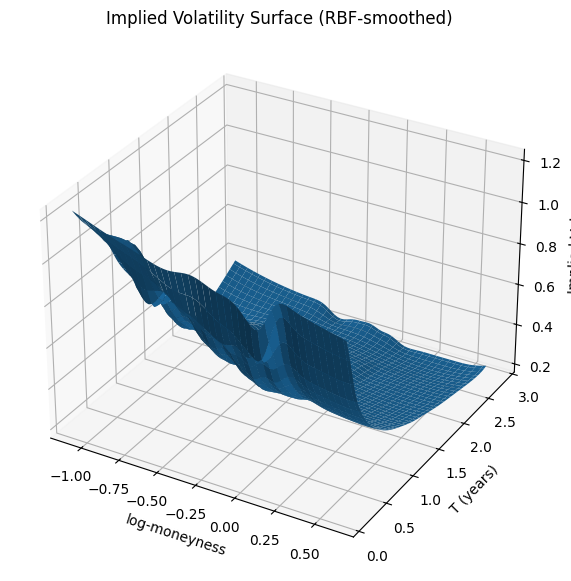

In [159]:
import numpy as np
from scipy.interpolate import Rbf
from scipy.spatial import Delaunay
import plotly.graph_objects as go
def plot_iv_surface(k, T, IV, grid_k=80, grid_T=80, rbf_smooth=0.02):
    """
    k:  1D array of log-moneyness
    T:  1D array of time to expiry (years)
    IV: 1D array of implied vols (decimal, e.g. 0.25)
    """
    k = np.asarray(k, dtype=float)
    T = np.asarray(T, dtype=float)
    IV = np.asarray(IV, dtype=float)

    # Filter any junk
    mask = np.isfinite(k) & np.isfinite(T) & np.isfinite(IV) & (T > 0) & (IV > 0)
    k, T, IV = k[mask], T[mask], IV[mask]

    peak_mask = IV > 1.3
    print(f"\nHigh IV points (>130%):")
    print(f"Count: {peak_mask.sum()}")
    if peak_mask.sum() > 0:
        print(f"Maturity range: {T[peak_mask].min()*365:.0f}-{T[peak_mask].max()*365:.0f} days")
        print(f"Moneyness range: {k[peak_mask].min():.2f} to {k[peak_mask].max():.2f}")
        print(f"IV range: {IV[peak_mask].min():.1%} to {IV[peak_mask].max():.1%}")

    if len(k) == 0:
        raise ValueError("No valid points to plot after filtering.")

    # Build a grid
    k_lin = np.linspace(k.min(), k.max(), grid_k)
    T_lin = np.linspace(T.min(), T.max(), grid_T)
    KK, TT = np.meshgrid(k_lin, T_lin)

    # Smooth interpolation: RBF
    rbf = Rbf(k, T, IV, function="multiquadric", smooth=rbf_smooth)
    IV_grid = rbf(KK, TT)

    # ---- 3D surface ----
    fig = plt.figure(100, figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(KK, TT, IV_grid, linewidth=0, antialiased=True)

    ax.set_xlabel("log-moneyness")
    ax.set_ylabel("T (years)")
    ax.set_zlabel("Implied Vol")
    ax.set_title("Implied Volatility Surface (RBF-smoothed)")
    plt.show()

# usage:
# k, T, IV = build_iv_points("TSLA", ...)
plot_iv_surface(k, T, IV, rbf_smooth=0.05)